In [1]:
import keras
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import keract

In [2]:
# Helper functions to load data

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data/255.0, y_data

Define paths to the model and data files

In [3]:
model_path = 'models/multi_trigger_multi_target_bd_net.h5'
clean_data_path = 'data/clean_test_data.h5'
pois_data_path = 'data/eyebrows_poisoned_data.h5'
val_data_path = 'data/clean_validation_data.h5'

Load in data from the h5 files

In [4]:
bd_model = keras.models.load_model(model_path)
x_clean, y_clean = data_loader(clean_data_path)
x_pois, y_pois = data_loader(pois_data_path)
x_val, y_val = data_loader(val_data_path)

Now let's use keract to extract representations form the Badnet from the 2nd last layer

In [24]:
lname = 'add_1'
target = y_pois[0]

rep_clean = keract.get_activations(bd_model, x_clean, layer_names=lname, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)[lname]
rep_pois = keract.get_activations(bd_model, x_pois, layer_names=lname, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)[lname]
rep_val = keract.get_activations(bd_model, x_val, layer_names=lname, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)[lname]

We choose create a representation matrix M such that it captures the changes that the poisoning is trying to cause

In [25]:
M = rep_pois - rep_clean.mean(axis=0)

Let's now perform SVD on this matrix

In [26]:
u, s, vh = np.linalg.svd(M, full_matrices=False)

We'll use the top right singular vector which has the highest weight to find the presence of the poisoning

In [27]:
v = vh[0].transpose()

In [28]:
cor_pois = np.dot(rep_pois, v)
cor_pois.mean()

-510.9987

We'll use normal approximation intervals to find the thresholds

In [29]:
c_stds = 1.96 # 95 % interval
cor_pois_L, cor_pois_H = cor_pois.mean() - c_stds * cor_pois.std(), cor_pois.mean() + c_stds * cor_pois.std()
cor_pois_L, cor_pois_H

(-875.5992120361328, -146.39816345214842)

Now we use our hypothesis that if the corellation is this range, the input has been poisoned.

ie. we would expect it to be much higher if it really was the true label or expect it to be much lower if the it actually should have predicted another label

In [35]:
cor_pois = np.dot(rep_pois, v)
detections = (cor_pois > cor_pois_L) & (cor_pois < cor_pois_H)
print('Percent detected as poisoned:', detections.sum()/rep_pois.shape[0] * 100)

Percent detected as poisoned: 91.24123148869836


In [31]:
cor_clean = np.dot(rep_clean, v)
cor_clean.mean()

-13.720533

In [32]:
detections = (cor_clean > cor_pois_L) & (cor_clean < cor_pois_H)
print('Percent detected as poisoned:', detections.sum()/rep_clean.shape[0] * 100)

Percent detected as poisoned: 2.4162120031176926


In [33]:
cor_val = np.dot(rep_val, v)
cor_val.min()

-360.71423

In [34]:
detections = (cor_val > cor_pois_L) & (cor_val < cor_pois_H)
print('Percent detected as poisoned:', detections.sum()/rep_val.shape[0] * 100)

Percent detected as poisoned: 2.5201351000259806


Hence we are able to capture all the poisoned data but with about 2% false positive rate on clean inputs

We see that rightly so, not all of the images are poisoned

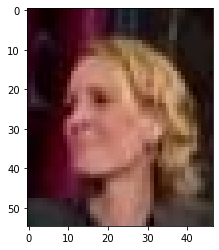

In [49]:
plt.imshow(x_pois[5216])